In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## Same plot but bootstrapped. Also, allow smaller s.

n = 2
Q = 10

df = pd.read_csv('./../../data/processed/ID_Y.csv')
df = df.sample(frac = 1).reset_index()

## Save adapted datasets

In [3]:

for i in [0, 1]:
    sales = df.loc[df.IMPORT == i].groupby(['ID', 'YEAR'])['VART'].sum().unstack()
#     sales = sales.loc[sales.sum(1).sort_values().index]

    # Choose firms with presence in most sample, to avoid high distortion filling exit gaps
    sales_filt = sales.loc[sales.count(1) > 6]
    filt_fm = sales_filt.copy()

    # Large firms pareto filled median. 
    for col in filt_fm:
        filt_fm[col] = filt_fm[col].fillna(sales_filt.mean(axis=1))

    # Hard cut for Pareto tail
    filt_fm = filt_fm.loc[filt_fm.mean(1) > 1e6]
    filt_fm.to_csv('./firms_data_'+str(i)+'.csv')
    
    X = sales.sum().mean()
    X_actives = sales_filt.sum().mean()
    X_act_lrg = filt_fm.sum().mean()

    ## Sanity checks. What is the total after we filled non active gaps and kept large firms
    print(X_actives/X)
    print(X_act_lrg/X_actives)
    print(X_act_lrg/X)

0.9463827153209998
1.1307943247278696
1.0701642035055376
0.9322847194208238
1.1314710872923615
1.0548532051491335


 
-1.138 x + 11.53
19232
 
-1.138 x + 11.59
28078


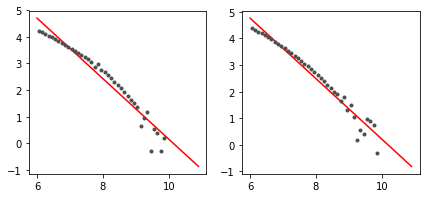

In [4]:
fig, axs = plt.subplots(1, 2, figsize = (7, 3))

pareto_z = np.zeros(2)
for i in [0, 1]:
    filt_fm = pd.read_csv('./firms_data_'+str(i)+'.csv', index_col=0)

    ## FIT PARETO
    log_vals = np.log10(filt_fm.mean(1))

    bins = pd.DataFrame(pd.cut(log_vals, np.arange(6, 10, .1)).dropna().value_counts(), columns=['n'])
    bins['mid'] = np.array([(b.mid).round(6) for b in bins.index.values])
    bins['CCDF'] = bins['n'].sum() - bins['n'].cumsum()
    bins['lCCDF'] = np.log10(bins['CCDF'] + .5)

    # bins.plot('mid', 'lCCDF', marker = '.', lw = 0)
    x = bins.mid.values; y = bins.lCCDF.values

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    xp = np.arange(6, 11, .1)

    ax = axs[i]
    ax.plot(xp, p(xp), '-', c = 'r', label='%.2f x + %.2f' % tuple(z))
    ax.plot(x, y, '.', label = 'observations', c = '.3')
    print(p)
    print(bins['n'].sum())
    pareto_z[i] = p[1]
plt.show()

In [5]:
pareto_z

array([-1.13818251, -1.1379412 ])

In [6]:
# filt_fm.sum(1).max()/filt_fm.sample(300).sum().sum()

In [7]:
## It would be nice to get the pareto exponents here...

# fig, ax = plt.subplots(1)

# np.log10(sales.mean(1)).hist(bins = np.arange(6, 11, .1), alpha = .3, ax = ax)
# np.log10(filt.mean(1)).hist(bins = np.arange(6, 11, .1), alpha = .3, ax = ax)
# np.log10(filt_fm.mean(1)).hist(bins = np.arange(6, 11, .1), alpha = .3, ax = ax)
# plt.yscale('log')
# plt.show()

In [8]:
# fig, axs = plt.subplots(1, 2, figsize = (14, 5))

# for i in [0, 1]:
#     filt_fm = pd.read_csv('./firms_data_'+str(i)+'.csv', index_col=0)

#     res_list = []
#     res_list_h = []

#     M = 50
    
#     logn_vals = np.arange(3, np.log10(len(filt_fm)), .25)
#     n_vals = np.round(10**logn_vals, -2)
    
#     for n in n_vals:
#         s_list = []
#         h_list = []

#         for m in range(M):
#             n_sample = filt_fm.sample(int(n))
#             s = np.log10(n_sample.sum()).std()
# #             s = n_sample.sum().std()/(np.log(10)*n_sample.sum().mean())
#             s_list += [s]
    
#             # Herfindahl
#             Si = n_sample.sum(1)
#             h = np.sqrt((Si**2).sum())/(Si).sum()
#             h_list += [h]

#         res_list += [s_list]
#         res_list_h += [h_list]

#     result = pd.DataFrame(res_list, index = n_vals)
#     result_h = pd.DataFrame(res_list_h, index = n_vals)

#     ax = axs[i]
#     ax.set_title(['std(log(X)) vs N \n Exports', 'std(log(X)) vs N \n Imports'][i])
# #     ax.set_title(['std(X)/(ln(10) X) vs N \n Exports', 'std(log(X)) vs N \n Imports'][i])
#     ax.fill_between(result.index, result.quantile(.25, 1), result.quantile(.75, 1), color = '.5', alpha = .25)
#     ax.plot(result.index, result.mean(1), color = 'k')
#     ax.set_ylim(0, .1)
#     ax.set_xlabel('Population N')
#     ax.set_ylabel('std')
    
# plt.savefig('./test_fig_1.png')
# plt.show()

In [9]:
## Compute Aggs and parts' time series

In [10]:
M = 150

xm_df_list = []
xm_Sp_list = []
xm_Sq_list = []

logn_vals = np.arange(2.5, 4, .15)
n_vals = np.round(10**logn_vals, -2)

for i in [0, 1]:
    filt_fm = pd.read_csv('./firms_data_'+str(i)+'.csv', index_col=0)

    N_df_list = []
    N_Sp_list = []
    N_Sq_list = []
    for N in n_vals:

        n_m_p_out_list = []
        n_m_q_out_list = []
        
        agg_res = []
#         for m in range(M):
        m = 0
        while m < M:
#             print(m)
            n_sample = filt_fm.sample(int(N), replace = True)
            
            n_sample_p = n_sample.copy()
            n_sample_p['p'] = pd.cut(n_sample_p.sum(1).cumsum(), Q, labels = range(Q))
            
            n_sample_q = n_sample.copy() 
            n_sample_q = n_sample_q.loc[n_sample_q.sum(1).sort_values().index]  ## SORTING
            n_sample_q['p'] = pd.cut(n_sample_q.sum(1).cumsum(), Q, labels = range(Q))
            
            min_n_test = min(n_sample_p.groupby('p').size().min(), n_sample_q.groupby('p').size().min())           
            if (min_n_test == 0): # It may happen that a quantile is empty. epsecially with low N. Sample again in that case. 
#                 print('min_0')
                pass

#             low_n_test = min(n_sample_p.groupby('p').size().min(), n_sample_q.groupby('p').size().iloc[:-1].min())
#             if (N > 500)*(low_n_test < 3): # Also, if quantiles (except )
#                 pass
            
    
    
            else: # Compute everything
                ## Calculate aggregate magnitudes
                X_t = n_sample.sum()
                Si = n_sample.mean(1)
                        #    'bar_X', 's2_X', 's2_logX', 'herf2'         # == (Si**2).sum()/(Si).sum()**2
                herf2 = ((Si/Si.sum())**2).sum()
                agg_res += [[m, X_t.mean(), X_t.std(), np.log10(X_t).std(), herf2, np.sqrt(herf2)]]


                ## Aggregate nonsorted parts
                n_m_p_out = n_sample_p.groupby('p').sum().reset_index()
                n_m_p_out['m'] = m; n_m_p_out['sorting'] = False
                n_m_p_out['n'] = n_sample_p.groupby('p').size().values
                n_m_p_out_list += [n_m_p_out]


                ## Aggregate sorted, quantile parts
                n_m_q_out = n_sample_q.groupby('p').sum().reset_index()
                n_m_q_out['m'] = m; n_m_q_out['sorting'] = True
                n_m_q_out['n'] = n_sample_q.groupby('p').size().values
                n_m_q_out_list += [n_m_q_out]
                
                m += 1 # count
                
            
        N_Sp_df = pd.concat(n_m_p_out_list); N_Sp_df['N'] = N; N_Sp_list += [N_Sp_df]
        N_Sq_df = pd.concat(n_m_q_out_list); N_Sq_df['N'] = N; N_Sq_list += [N_Sq_df]
            
        N_df = pd.DataFrame(agg_res, columns = ['m', 'bar_X', 's2_X', 's2_logX', 'herf2', 'herf']); N_df['N'] = N; N_df_list += [N_df]
        
    xm_Sp_df = pd.concat(N_Sp_list); xm_Sp_df['IMPORT'] = i; xm_Sp_list += [xm_Sp_df]
    xm_Sq_df = pd.concat(N_Sq_list); xm_Sq_df['IMPORT'] = i; xm_Sq_list += [xm_Sq_df]

    xm_df = pd.concat(N_df_list); xm_df['IMPORT'] = i; xm_df_list += [xm_df]

result_aggs = pd.concat(xm_df_list)
result_Sp = pd.concat(xm_Sp_list)
result_Sq = pd.concat(xm_Sq_list)


In [11]:
min_n_test

6

### Check nqs

In [12]:
result_Sq.groupby(['p', 'sorting', 'N', 'IMPORT'])[['n']].mean().unstack([-1, -2])

n                                                  \
IMPORT              0           1           0           1           0   
N              300.0       300.0       400.0       400.0       600.0    
p sorting                                                               
0 True     194.366667  170.373333  267.860000  237.900000  412.840000   
1 True      53.306667   61.153333   70.900000   80.726667  105.880000   
2 True      23.886667   29.980000   30.286667   37.980000   44.940000   
3 True      12.826667   16.613333   15.766667   20.420000   22.573333   
4 True       7.506667    9.766667    9.253333   11.440000   12.940000   
5 True       4.773333    6.140000    5.586667    6.860000    7.886667   
6 True       3.146667    3.713333    3.660000    4.226667    4.900000   
7 True       2.120000    2.500000    2.353333    2.660000    3.233333   
8 True       1.486667    1.580000    1.653333    1.766667    2.006667   
9 True       1.513333    1.513333    1.586667    1.646667    1.786667   

                                                                       \
IMPORT              1           0           1           0           1   
N              600.0       900.0       900.0       1300.0      1300.0   
p sorting                                                               
0 True     368.993333  647.900000  570.220000  956.153333  837.280000   
1 True     122.193333  154.826667  182.573333  230.193333  267.313333   
2 True      55.673333   63.793333   82.360000   94.233333  119.673333   
3 True      28.966667   31.940000   42.126667   47.113333   60.953333   
4 True      15.613333   17.526667   22.653333   26.153333   32.873333   
5 True       9.053333   10.326667   12.400000   15.420000   18.526667   
6 True       5.400000    6.380000    7.293333    9.360000   10.486667   
7 True       3.206667    3.840000    4.306667    5.580000    5.993333   
8 True       2.106667    2.406667    2.546667    3.160000    3.340000   
9 True       1.686667    1.873333    1.893333    2.246667    2.306667   

                                                                            \
IMPORT               0            1            0            1            0   
N               1800.0       1800.0       2500.0       2500.0       3500.0   
p sorting                                                                    
0 True     1361.893333  1203.686667  1981.753333  1733.860000  2921.760000   
1 True      323.680000   372.580000   456.960000   525.826667   663.220000   
2 True      133.240000   163.446667   182.560000   229.106667   263.580000   
3 True       65.953333    82.100000    89.306667   112.800000   129.326667   
4 True       36.266667    43.353333    48.620000    57.700000    69.533333   
5 True       21.093333    23.353333    28.066667    30.806667    39.193333   
6 True       12.440000    13.000000    16.393333    16.933333    22.246667   
7 True        7.333333     7.133333     9.080000     9.026667    12.726667   
8 True        4.093333     3.793333     4.933333     4.760000     6.720000   
9 True        2.580000     2.420000     2.846667     2.726667     3.586667   

                                                                            
IMPORT               1            0            1            0            1  
N               3500.0       5000.0       5000.0       7100.0       7100.0  
p sorting                                                                   
0 True     2559.433333  4502.040000  3878.860000  6984.260000  5834.466667  
1 True      748.406667   999.500000  1109.660000  1525.380000  1691.546667  
2 True      316.813333   392.140000   464.173333   595.613333   708.406667  
3 True      152.326667   189.520000   219.486667   289.526667   335.333333  
4 True       75.886667   100.580000   108.626667   154.006667   164.773333  
5 True       39.460000    56.680000    55.720000    86.146667    84.506667  
6 True       21.273333    32.293333    29.320000    48.493333    44.546667  
7 True       10.846667    17.18666

In [13]:
# z == 1/(-0.32 + 1)?
1/(-0.6482/2 + 1)

1.4795088030773784

In [14]:
# result_aggs.loc[(result_aggs.m == 15)].drop_duplicates()

### Separate BASE from SHOCKS. 

In [15]:
### Ver si esto no se puede hacer dos de una ya que ay columna sorting... creo que no..

In [16]:
## RANDOM PARTS

medians_p = result_Sp.drop(['n', 'sorting'], axis = 1).groupby(['IMPORT', 'N', 'p']).transform('median'); 
medians_p.index = pd.MultiIndex.from_arrays(result_Sp[['IMPORT','N', 'p']].values.T); medians_p.index.names = ['IMPORT','N', 'p']

res_nmp = result_Sp.drop(['n', 'sorting'], axis = 1).set_index(['IMPORT','N', 'p']) - medians_p; 

## Organize info
medians_p['m'] = result_Sp['m'].values; medians_p['n'] = result_Sp['n'].values; medians_p['comp'] = 'm'; medians_p['sorting'] = False; medians_p = medians_p.reset_index()
res_nmp['m'] = result_Sp['m'].values; res_nmp['n'] = result_Sp['n'].values; res_nmp['comp'] = 'se'; res_nmp['sorting'] = False; res_nmp = res_nmp.reset_index()

info_p = pd.concat([medians_p, res_nmp])


### QUANTILE PARTS
medians_q = result_Sq.drop(['n', 'sorting'], axis = 1).groupby(['IMPORT', 'N', 'p']).transform('median'); 
medians_q.index = pd.MultiIndex.from_arrays(result_Sq[['IMPORT','N', 'p']].values.T); medians_q.index.names = ['IMPORT','N', 'p']

res_nmq = result_Sq.drop(['n', 'sorting'], axis = 1).set_index(['IMPORT','N', 'p']) - medians_q; 

## Organize info
medians_q['m'] = result_Sq['m'].values; medians_q['n'] = result_Sq['n'].values; medians_q['comp'] = 'm'; medians_q['sorting'] = True; medians_q = medians_q.reset_index()
res_nmq['m'] = result_Sq['m'].values; res_nmq['n'] = result_Sq['n'].values; res_nmq['comp'] = 'se'; res_nmp['sorting'] = True; res_nmq = res_nmq.reset_index()

info_q = pd.concat([medians_q, res_nmq])

/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



### Compute COV elements

In [17]:

cov_out_list = []

for i in [0, 1]:
    for N in n_vals:
        for m in range(M):
            for k, sorting in enumerate([False, True]):
                info = [info_p, info_q][k]
                df_ = info.loc[(info.IMPORT == i) & (info.m == m) & (info['N'] == N)]
                df_ = df_.set_index(['comp', 'p'])[[str(y) for y in range(1997, 2013)]]
                cov_m = df_.T.cov()

                cov_vals = cov_m.stack([0, 1])
                cov_vals.index.names = ['comp1', 'p1', 'comp2', 'p2']; cov_vals.name = 'cov_ij'

                cov_vals = pd.DataFrame(cov_vals.reset_index())
                cov_vals['m'] = m; cov_vals['N'] = N; cov_vals['IMPORT'] = i; cov_vals['sorting'] = sorting;

                cov_out_list += [cov_vals]
            
cov_results = pd.concat(cov_out_list)


In [18]:
cov_m.head()

comp               m                                                          \
p                  0             1             2             3             4   
comp p                                                                         
m    0  2.096320e+18  2.066009e+18  2.050336e+18  2.064980e+18  1.695164e+18   
     1  2.066009e+18  2.054008e+18  2.029660e+18  2.034316e+18  1.675197e+18   
     2  2.050336e+18  2.029660e+18  2.064133e+18  2.053841e+18  1.674418e+18   
     3  2.064980e+18  2.034316e+18  2.053841e+18  2.081732e+18  1.705249e+18   
     4  1.695164e+18  1.675197e+18  1.674418e+18  1.705249e+18  1.455491e+18   

comp                                                                          \
p                  5             6             7             8             9   
comp p                                                                         
m    0  2.103255e+18  2.506986e+18  2.444879e+18  2.100115e+18  3.660925e+18   
     1  2.102615e+18  2.516059e+18  2.419843e+18  2.054539e+18  3.550645e+18   
     2  2.095378e+18  2.514019e+18  2.430711e+18  2.101010e+18  3.776685e+18   
     3  2.100450e+18  2.503095e+18  2.420202e+18  2.104168e+18  3.727899e+18   
     4  1.758021e+18  2.052276e+18  1.965724e+18  1.705690e+18  2.934709e+18   

comp              se                                                          \
p                  0             1             2             3             4   
comp p                                                                         
m    0 -4.396475e+16 -3.632730e+17 -1.109905e+15  7.758676e+16 -1.002899e+18   
     1 -3.649705e+16 -3.571151e+17  8.048962e+15  3.675906e+16 -1.007219e+18   
     2 -2.721154e+16 -3.696969e+17 -6.037817e+16  1.144898e+16 -1.000942e+18   
     3 -3.276337e+16 -3.730584e+17 -3.220489e+16  4.501347e+16 -9.707206e+17   
     4 -3.331778e+16 -3.020037e+17  2.119405e+16  8.322167e+16 -7.573686e+17   

comp                                                                          
p                  5             6             7             8             9  
comp p                                                                        
m    0  1.478623e+18 -1.265321e+18 -5.029419e+16  9.970492e+17 -2.413583e+18  
     1  1.460293e+18 -1.229352e+18 -3.842040e+16  1.005186e+18 -2.412878e+18  
     2  1.510793e+18 -1.346026e+18  3.922052e+16  1.008044e+18 -2.517499e+18  
     3  1.527679e+18 -1.319828e+18  1.678888e+16  1.014747e+18 -2.396007e+18  
     4  1.176151e+18 -9.975871e+17 -2.502819e+16  8.388076e+17 -1.846928e+18

In [19]:
# E_cov = cov_results.groupby(['comp1','q1','comp2','q2','N','IMPORT'])[['cov_ij']].mean().reset_index()

In [20]:
df = cov_results.copy()

df.loc[(df.comp1 == 'm') & (df.comp2 == 'm'), 'block'] = 'M'
df.loc[(df.comp1 == 'se') & (df.comp2 == 'se') & (df.p1 == df.p2), 'block'] = 'E' + df.loc[(df.comp1 == 'se') & (df.comp2 == 'se') & (df.p1 == df.p2), 'p1'].astype(str)
df.loc[(df.comp1 == 'se') & (df.comp2 == 'se') & (df.p1 != df.p2), 'block'] = 'Eij'
df.loc[df.comp1 != df.comp2, 'block'] = 'ME'

blocks = df.groupby(['sorting','block', 'm', 'N', 'IMPORT'])[['cov_ij']].sum().reset_index()

# blocks = blocks.merge(result_aggs[['m','N','IMPORT','bar_X']], on = ['m','N','IMPORT'])
# blocks['var_logX'] = blocks['cov_ij']/(np.log(10)*blocks['bar_X'])**2

In [21]:
sigma_eps_blocks = blocks.loc[~blocks.block.isin(['Eij', 'ME', 'M'])]
sigma_eps_blocks['p'] = sigma_eps_blocks.block.str[-1].astype(int)

/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
result_Sp['bar_Sp'] = result_Sp[[str(y) for y in range(1997, 2014)]].mean(1)
result_Sq['bar_Sp'] = result_Sq[[str(y) for y in range(1997, 2014)]].mean(1)
bar_Sp = pd.concat([result_Sp, result_Sq])[['sorting','N', 'IMPORT', 'm','p', 'bar_Sp']]


sigma_eps_blocks = sigma_eps_blocks.merge(bar_Sp, on = ['sorting','N','IMPORT', 'p', 'm'], how = 'left')

sigma_eps_blocks['var_logSp'] = sigma_eps_blocks['cov_ij']/(np.log(10)*sigma_eps_blocks['bar_Sp'])**2

In [23]:
#### Detect outliers
sigma_eps_blocks['outlier'] = ((sigma_eps_blocks.var_logSp - sigma_eps_blocks.var_logSp.median() )/ (sigma_eps_blocks.var_logSp.quantile(.75) - sigma_eps_blocks.var_logSp.quantile(.25)))


### Check herfindahl decay

In [24]:
# set(sigma_eps_blocks.columns).intersection(set(result_aggs.columns))
herf_data = result_aggs[['IMPORT', 'N', 'm','herf2','herf', 'bar_X']]

sigma_eps_ = sigma_eps_blocks

### First remove outliers, then continue
sigma_eps_ = sigma_eps_.loc[sigma_eps_.outlier < 50]
sigma_eps_ = sigma_eps_.groupby(['IMPORT', 'N', 'm','sorting'])[['cov_ij']].sum().reset_index()
sigma_eps_herf = sigma_eps_.merge(herf_data, on = ['IMPORT', 'N', 'm'])

sigma_eps_herf['var_logX'] = sigma_eps_herf['cov_ij'] / (np.log(10)*sigma_eps_herf['bar_X'])**2

sigma_eps_herf['sigma_eff1'] = sigma_eps_herf['var_logX']/sigma_eps_herf['herf2']
# sigma_eps_herf['sigma_eff2'] = sigma_eps_herf['var_logX']/sigma_eps_herf['herf']**2 ## Exactamente lo mismo

herf_info = sigma_eps_herf.groupby(['IMPORT', 'sorting', 'N'])[['var_logX', 'herf2', 'sigma_eff1']].describe()

fit var_lX_1
 
-0.2398 x - 2.124
fit herf
 
-0.403 x - 0.473
fit var_lX_1
 
-0.3593 x - 1.784
fit herf
 
-0.3307 x - 0.692


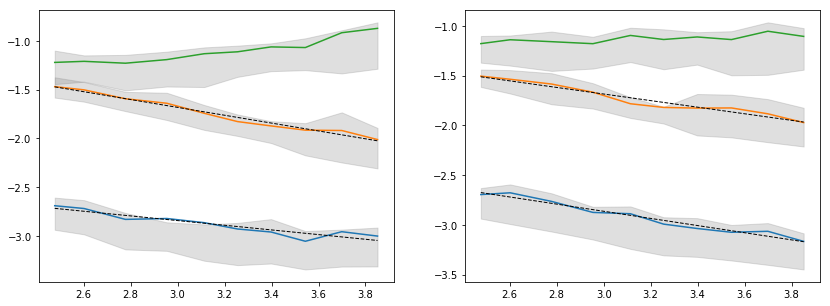

In [25]:
sorting_agg = False
fig, axs = plt.subplots(1, 2, figsize = (14, 5))

for i in [0, 1]:
    ax = axs[i]
    plot_data_0 = np.log10(herf_info.loc[i, sorting].reset_index())
    
    x = plot_data_0['N'].values
    ym = plot_data_0['var_logX']['mean'].values
    y1 = plot_data_0['var_logX']['25%'].values
    y2 = plot_data_0['var_logX']['75%'].values
    ax.plot(x, ym)
    ax.fill_between(x, y1, y2, color = '.5', alpha = .25)
    
    z = np.polyfit(x, ym, 1)
    poly = np.poly1d(z); print('fit var_lX_1'); print(poly)
    xp = np.linspace(min(x), max(x), 2)
    ax.plot(xp, poly(xp), color = 'k', lw = 1, linestyle = '--')
    
        
    x = plot_data_0['N'].values
    ym = plot_data_0['herf2']['mean'].values
    y1 = plot_data_0['herf2']['25%'].values
    y2 = plot_data_0['herf2']['75%'].values
    ax.plot(x, ym)
    ax.fill_between(x, y1, y2, color = '.5', alpha = .25)
    
    z = np.polyfit(x, ym, 1)
    poly = np.poly1d(z); print('fit herf'); print(poly)
    print('Gab. decay:'); zeta = pareto_z[i]; print(str(2*(1/zeta - 1)))
    
    xp = np.linspace(min(x), max(x), 2)
    ax.plot(xp, poly(xp), color = 'k', lw = 1, linestyle = '--')
        
    x = plot_data_0['N'].values
    ym = plot_data_0['sigma_eff1']['mean'].values
    y1 = plot_data_0['sigma_eff1']['25%'].values
    y2 = plot_data_0['sigma_eff1']['75%'].values
    ax.plot(x, ym)
    ax.fill_between(x, y1, y2, color = '.5', alpha = .25)
    
    
for i in [0, 1]:
    ax = axs[i]
    ax.set_title(['EXPORTS', 'IMPORTS'][i])
    ax.set_xlabel('log(n)')
    ax.set_ylabel(r'$log(\sigma ^2) = 2 log(\sigma)$')

#     ax = axs[i]
#     Ps_data = block_var_n.loc[(block_var_n.IMPORT == i) & (block_var_n.sorting == sorting)]
#     x = np.log10(Ps_data.n)
#     y = np.log10(Ps_data.var_logSp)
#     z = np.polyfit(x, y, 1)
#     poly = np.poly1d(z); print('fit var_lX_2'); print(poly)
#     xp = np.linspace(min(x), max(x), 2)
#     ax.plot(xp, poly(xp))
#     ax.plot(xp + 1, poly(xp) - 1)
    
    
plt.show()

### Remove outliers

In [26]:
sigma_eps_blocks = sigma_eps_blocks.loc[sigma_eps_blocks['outlier'] < 50]; sigma_eps_blocks = sigma_eps_blocks.drop('outlier', axis = 1)

In [27]:
## Hacerle unos zscore y tirar outcome si se va muchos sigma. Para porque a veces un quantile queda con 1 solo agente porque lo tapo el quantile anterior

# data_sel = sigma_eps_blocks.loc[(sigma_eps_blocks.sorting == False) & (sigma_eps_blocks.IMPORT == 1) & (sigma_eps_blocks.N == 7100) & (sigma_eps_blocks.p == 5)]#['cov_ij']

# pd.options.display.max_rows = 500

# .sort_values().tail(50)

# .reset_index(drop = True).plot()#.loc[17375: 17385]

# .sort_values()

In [28]:
# data_sel = sigma_eps_blocks.loc[(sigma_eps_blocks.sorting == False) & (sigma_eps_blocks.IMPORT == 1) & (sigma_eps_blocks.N == 7100) & (sigma_eps_blocks.p == 5)]#['cov_ij']

# # data_sel[['cov_ij','bar_Sp','var_logSp']].describe()


# data_sel.loc[data_sel.var_logSp > 1]

In [29]:
# result_Sp.loc[(result_Sp.sorting == False) & (result_Sp.IMPORT == 1) & (result_Sp.N == 7100) & (result_Sp.p == 5) & (result_Sp.m == 118)]

In [30]:
# result_Sp.loc[result_Sp[[str(y) for y in range(1997, 2014)]].mean(1) == 0]

# (result_Sp[[str(y) for y in range(1997, 2014)]].mean(1) == 0).sum()/len(result_Sp)

In [31]:
# xx # Seguir aca...

In [32]:
# blocks.groupby(['block', 'N', 'IMPORT'])[['var_logX']].describe()

In [33]:

# var_all = (df.sum()/(np.log(10)**2*X_df**2).T).T
# var_pst = (df.drop(['Eij', 'ME']).sum()/(np.log(10)**2*X_df**2).T).T  ## Dropping expected-zero elements
# var_idy = (df.drop(['Eij', 'ME', 'M']).sum()/(np.log(10)**2*X_df**2).T).T # Total idiosynchratic variances.
# var_com = (df.loc[['M']].sum()/(np.log(10)**2*X_df**2).T).T ## Only comovement variance

# (var_idy + var_com)/var_all

In [34]:

#     ### Cov Matrix
#     info = pd.concat([medians, res_nmq])

#     X_n += [np.mean(np.array(X_list))]
    
#     cov_vals = []
#     for m in range(M):
#         cov_m = info.loc[info.m == m].drop('m', axis = 1).set_index(['comp', 'q']).T.cov() #
#         cov_vals += [cov_m.stack([0, 1])]


#     n_cov_vals = pd.concat(cov_vals, axis = 1)

#     df = n_cov_vals.copy()
#     df.index.names = ['comp1', 'q1', 'comp2', 'q2']

#     df = df.reset_index()

#     df.loc[(df.comp1 == 'm') & (df.comp2 == 'm'), 'block'] = 'M'
#     df.loc[(df.comp1 == 'se') & (df.comp2 == 'se') & (df.q1 == df.q2), 'block'] = 'E' + df.loc[(df.comp1 == 'se') & (df.comp2 == 'se') & (df.q1 == df.q2), 'q1'].astype(str)
#     df.loc[(df.comp1 == 'se') & (df.comp2 == 'se') & (df.q1 != df.q2), 'block'] = 'Eij'
#     df.loc[df.comp1 != df.comp2, 'block'] = 'ME'

#     block_sums_n = df.groupby('block')[np.arange(M)].sum()
#     block_vals = pd.DataFrame(block_sums_n.mean(1), columns=[n])
#     block_res += [block_vals]
    
# X_df = pd.DataFrame(X_n, index = n_vals, columns = ['bar X'])

In [35]:

# var_all = (df.sum()/(np.log(10)**2*X_df**2).T).T
# var_pst = (df.drop(['Eij', 'ME']).sum()/(np.log(10)**2*X_df**2).T).T  ## Dropping expected-zero elements
# var_idy = (df.drop(['Eij', 'ME', 'M']).sum()/(np.log(10)**2*X_df**2).T).T # Total idiosynchratic variances.
# var_com = (df.loc[['M']].sum()/(np.log(10)**2*X_df**2).T).T ## Only comovement variance

# (var_idy + var_com)/var_all

### Check the dependencies with population size...

In [36]:
sigma_eps_var = sigma_eps_blocks.groupby(['sorting', 'N', 'm', 'IMPORT'])[['cov_ij']].sum().reset_index()
sigma_eps_var = sigma_eps_var.merge(result_aggs[['m','N','IMPORT','bar_X']], how = 'left')
sigma_eps_var['var_logX'] = sigma_eps_var['cov_ij']/(np.log(10)*sigma_eps_var['bar_X'])**2

agg_plot_data = sigma_eps_var.groupby(['IMPORT', 'sorting', 'N'])['var_logX'].describe()#.reset_index()

In [37]:
# blocks = blocks.merge(result_aggs[['m','N','IMPORT','bar_X']], on = ['m','N','IMPORT'])


In [38]:
# data_q = info_q.groupby(['IMPORT', 'N', 'comp', 'm']).sum().drop(['p', 'n'], axis =1).reset_index()
# data_q['var_Sp'] = data_q[[str(y) for y in range(1997, 2014)]].var(1)

# var_table_q = data_q.groupby(['IMPORT', 'comp', 'N'])['var_Sp'].describe()

# plot_data_1 = var_table_q.loc[var_table_q.index.get_level_values('comp') == 'se'].drop('count', axis = 1)

# ### En realidad tendria que ver de dividir a cada caso por su propio barX pero bue.... 
# bar_Xs = result_aggs.groupby(['IMPORT', 'N'])['bar_X'].mean()

# plot_data_1 = plot_data_1.div((np.log(10)*bar_Xs.values)**2, axis = 0)

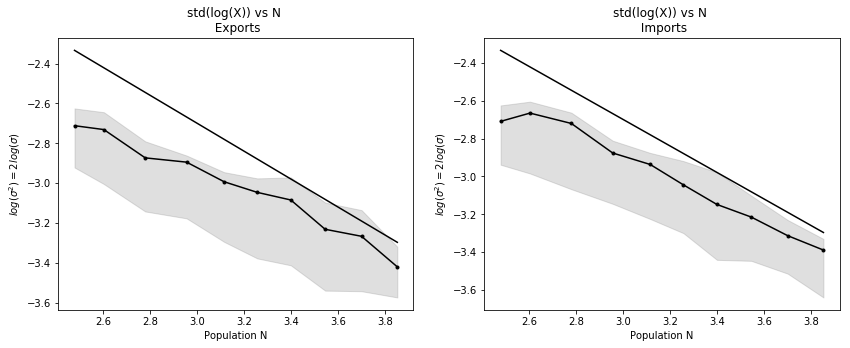

In [39]:
sorting_agg = False
fig, axs = plt.subplots(1, 2, figsize = (14, 5))

for i in [0, 1]:
    data = agg_plot_data.loc[i, sorting_agg]
    ax = axs[i]
    ax.set_title(['std(log(X)) vs N \n Exports', 'std(log(X)) vs N \n Imports'][i])
    
    x = np.log10(data.index.values)
    y1 = np.log10(data['25%'].values)
    y2 = np.log10(data['75%'].values)
    y3 = np.log10(data['mean'].values)
    
    ax.fill_between(x, y1, y2, color = '.5', alpha = .25)
    ax.plot(x, y3, color = 'k', marker = '.')
    ax.plot(x,  -.7*x-.6, color = 'k')
#     ax.set_ylim(0, .1)
    ax.set_xlabel('Population N')
    ax.set_ylabel(r'$log(\sigma ^2) = 2 log(\sigma)$')
    
plt.show()

In [40]:
### Why does it differ between sorting and not sorting?? I believe I am using the same data, the aggregate should be the same.
# The estimated medians however are different, and so the idyosinchracies are different.

In [41]:
nps = result_Sp.groupby(['N','IMPORT', 'p'])['n'].describe()[['mean']].reset_index(); nps['sorting'] = False
nps_block = nps.copy(); nps_block['block'] = 'E'+nps_block['p'].astype(str)
nps_block = nps_block.rename(columns = {'mean': 'n'})

nqs = result_Sq.groupby(['N','IMPORT', 'p'])['n'].describe()[['mean']].reset_index(); nqs['sorting'] = True
nqs_block = nqs.copy(); nqs_block['block'] = 'E'+nqs_block['p'].astype(str)
nqs_block = nqs_block.rename(columns = {'mean': 'n'})

# blocks_var = blocks.groupby(['block','N','IMPORT','sorting'])[['var_logX']].mean().reset_index()
blocks_var = sigma_eps_blocks.groupby(['block','N','IMPORT','sorting'])[['var_logSp']].mean().reset_index()

In [42]:
block_var_n = blocks_var.merge(pd.concat([nps_block, nqs_block]), on = ['sorting', 'N', 'IMPORT', 'block'])

In [43]:
def percentile_lo (x): 
    return np.percentile(x, q=10)
def percentile_hi (x): 
    return np.percentile(x, q=90)

 
-0.4792 x - 1.033
 
-0.4854 x - 0.9855


alpha                                                              \
       count      mean       std       min       25%       50%       75%   
IMPORT                                                                     
0       10.0 -0.475491  0.039298 -0.562731 -0.486330 -0.466520 -0.457377   
1       10.0 -0.482067  0.042534 -0.548012 -0.502535 -0.481119 -0.461764   

                  
             max  
IMPORT            
0      -0.424623  
1      -0.406907

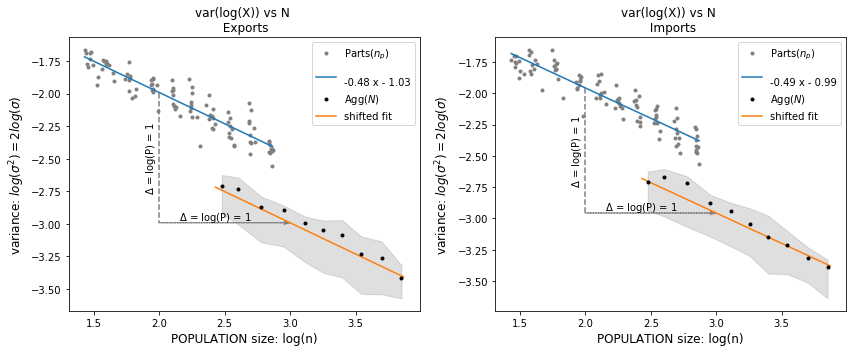

In [151]:
sorting = False

fig, axs = plt.subplots(1, 2, figsize = (12, 5))


poly_list = []
for i in [0, 1]:
    ax = axs[i]
    for p in range(Q):
        plot_data_2 = block_var_n.loc[(block_var_n.IMPORT == i) & (block_var_n.p == p) & (block_var_n.sorting == sorting)]

        x = np.log10(plot_data_2['n'].values); y = np.log10(plot_data_2.var_logSp.values);

        prt_points, = ax.plot(x, y, marker = '.', c = '.5', lw = 0, label = 'prt_points')   # Color Lines for quantiles

        z = np.polyfit(x, y, 1)
        poly = np.poly1d(z)
    #     xp = np.arange(3, 4.5, .25) 
        poly_list += [[i, p, poly[1]]]

        
    ##### FITS OF PARTS DATA
    Ps_data = block_var_n.loc[(block_var_n.IMPORT == i) & (block_var_n.sorting == sorting)]
    x = np.log10(Ps_data.n)
    y = np.log10(Ps_data.var_logSp)
    z = np.polyfit(x, y, 1)
    poly = np.poly1d(z); print(poly)
    xp = np.linspace(min(x), max(x), 2)
    prt_fit, = ax.plot(xp, poly(xp))
    prt_fit_1, = ax.plot(xp + 1, poly(xp) - 1)


    ##### PLOT AGGREGATE DATA
    data = agg_plot_data.loc[i, sorting_agg]
    
    x = np.log10(data.index.values)
    y1 = np.log10(data['25%'].values)
    y2 = np.log10(data['75%'].values)
    y3 = np.log10(data['mean'].values)
    
    ax.fill_between(x, y1, y2, color = '.5', alpha = .25)
    agg_points, = ax.plot(x, y3, color = 'k', marker = '.', lw = 0, label = 'agg_points')

    ## LEGEND
    ax.legend([prt_points, prt_fit, agg_points, prt_fit_1], ['Parts'+r'$(n_p)$', str(np.poly1d(z.round(decimals=2))), 'Agg'+r'$(N)$', 'shifted fit'])

    #### Shift demo:
    x0, y0 = 2, poly(2)
    x1, y1 = x0 + np.log10(Q), y0 - np.log10(Q)
    ax.plot([x0, x0], [y0, y1], c = '.5', linestyle = '--')
#     ax.plot([x0, x1], [y1, y1], c = '.5', lw = 0)
    ax.arrow(x0, y1, 1, 0, head_width = .03, length_includes_head = True, color = '.5', linestyle = '--')
    ax.annotate(r'$\Delta$'+' = log(P) = 1', xy=((x0 + x1)/2 - .35, y1+0.02))#, xytext=(0, 0))
    ax.annotate(r'$\Delta$'+' = log(P) = 1', xy=(x0-.12, (y0 + y1)/2), rotation = 90, va = 'center')#, xytext=(0, 0))
    

display(pd.DataFrame(poly_list, columns = ['IMPORT', 'p', 'alpha']).groupby(['IMPORT'])[['alpha']].describe())


for i in [0, 1]:
    ax = axs[i]
    for N in n_vals:
        plot_data_3 = block_var_n.loc[(block_var_n.IMPORT == i) & (block_var_n.sorting == sorting) & (block_var_n.N == N) ]
#         plot_data_2 = block_var_n.loc[(block_var_n.IMPORT == i) & (block_var_n.p == p) & (block_var_n.sorting == sorting)]
        x = np.log10(plot_data_3['n'].values); y = np.log10(plot_data_3.var_logSp.values);
        ax.plot(x, y, c = '.5', lw = 0) # Gray Lines for each N
        
        
result = pd.read_csv('./experiment_3.csv')
plot_data = result.loc[result.dist == 'emp'].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

# fig, ax = plt.subplots()
if sorting:
    ax = axs[i]

    for s in [0.30000000000000004, 0.4]:
        data = plot_data.loc[s]['std']

        x = np.log10(data.index.values)
        y1 = 2*np.log10(data['mean'].values)
        plt.plot(x, y1, c = '.5', lw = 1)
    
for i in [0, 1]:
    ax = axs[i]
    ax.set_title(['var(log(X)) vs N \n Exports', 'var(log(X)) vs N \n Imports'][i], fontsize = 12)
    ax.set_xlabel('POPULATION size: log(n)', fontsize = 12)
    ax.set_ylabel('variance: '+r'$log(\sigma ^2) = 2 log(\sigma)$', fontsize = 12)
    
filetag = ['P', 'Q'][sorting]
plt.tight_layout()

plt.savefig('./../../../WRITING/paper1_writing/figures/N_decay_'+filetag+'.png')

plt.show()

### Watching the two slopes in detail

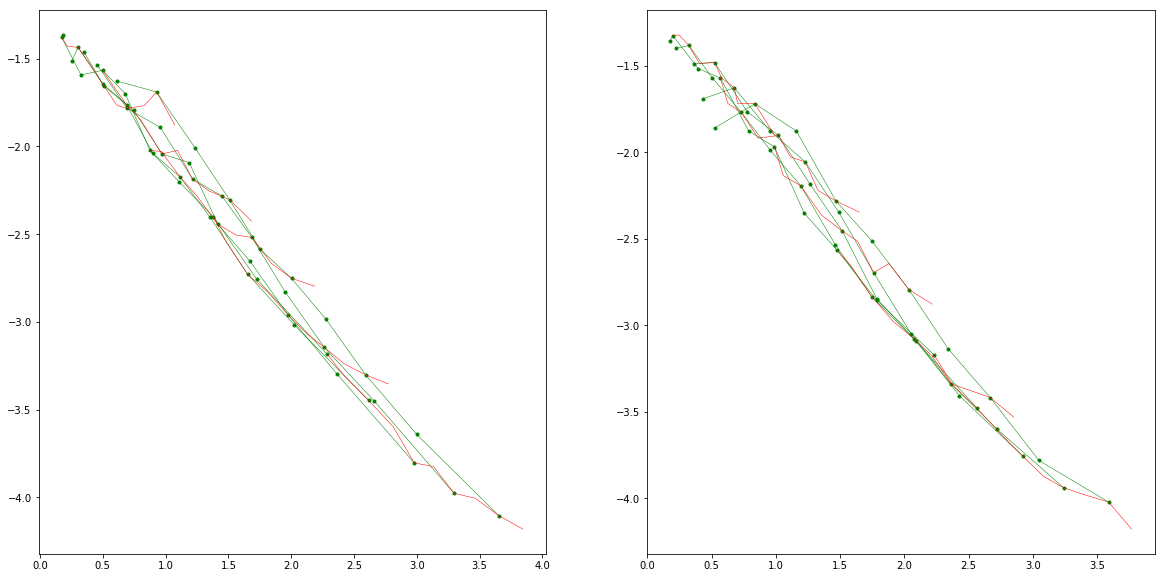

In [57]:
sorting = True

fig, axs = plt.subplots(1, 2, figsize = (20, 10))

poly_list = []
for i in [0, 1]:
    ax = axs[i]
    for N in n_vals[::2]:
        plot_data_3 = block_var_n.loc[(block_var_n.IMPORT == i) & (block_var_n.sorting == sorting) & (block_var_n.N == N) ]
#         plot_data_2 = block_var_n.loc[(block_var_n.IMPORT == i) & (block_var_n.p == p) & (block_var_n.sorting == sorting)]
        x = np.log10(plot_data_3['n'].values); y = np.log10(plot_data_3.var_logSp.values);
        ax.plot(x, y, marker = '.', c = 'g', lw = .5)

    
for i in [0, 1]:
    ax = axs[i]
    for p in range(Q)[::2]:
        plot_data_2 = block_var_n.loc[(block_var_n.IMPORT == i) & (block_var_n.p == p) & (block_var_n.sorting == sorting)]

        x = np.log10(plot_data_2['n'].values); y = np.log10(plot_data_2.var_logSp.values);

        ax.plot(x, y, c = 'r', lw = .5)   # Color Lines for quantiles
        
        
# display(pd.DataFrame(poly_list, columns = ['IMPORT', 'p', 'alpha']).groupby(['IMPORT'])[['alpha']].describe())


### The slope that should match decay of N. (roughly, note they are curves).

alpha                                                              \
       count      mean       std       min       25%       50%       75%   
IMPORT                                                                     
0       10.0 -0.642969  0.080601 -0.717267 -0.702215 -0.663559 -0.634916   
1       10.0 -0.766679  0.246500 -1.460943 -0.718824 -0.707404 -0.687478   

                  
             max  
IMPORT            
0      -0.479846  
1      -0.616692

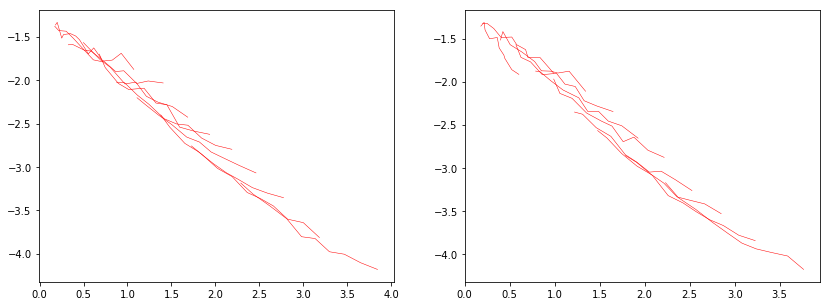

In [64]:
sorting = True

fig, axs = plt.subplots(1, 2, figsize = (14, 5))

poly_list = []
for i in [0, 1]:
    ax = axs[i]
    for p in range(Q):
        plot_data_2 = block_var_n.loc[(block_var_n.IMPORT == i) & (block_var_n.p == p) & (block_var_n.sorting == sorting)]
        x = np.log10(plot_data_2['n'].values); y = np.log10(plot_data_2.var_logSp.values);
        ax.plot(x, y, c = 'r', lw = .5)   # Color Lines for quantiles
        
        z = np.polyfit(x, y, 1)
        poly = np.poly1d(z)
    #     xp = np.arange(3, 4.5, .25) 
        poly_list += [[i, p, poly[1]]]
        
display(pd.DataFrame(poly_list, columns = ['IMPORT', 'p', 'alpha']).groupby(['IMPORT'])[['alpha']].describe())
    

### The slope that should match the experiment 3

 
-0.9335 x - 1.078
 
-0.7874 x - 0.9138
 
-0.9335 x - 1.078
 
-0.7874 x - 0.9138


alpha                                                              \
       count      mean       std       min       25%       50%       75%   
IMPORT                                                                     
0       10.0 -0.866977  0.017414 -0.898672 -0.871073 -0.867696 -0.865554   
1       10.0 -0.902550  0.057691 -0.969329 -0.939511 -0.919909 -0.859047   

                  
             max  
IMPORT            
0      -0.837292  
1      -0.803203

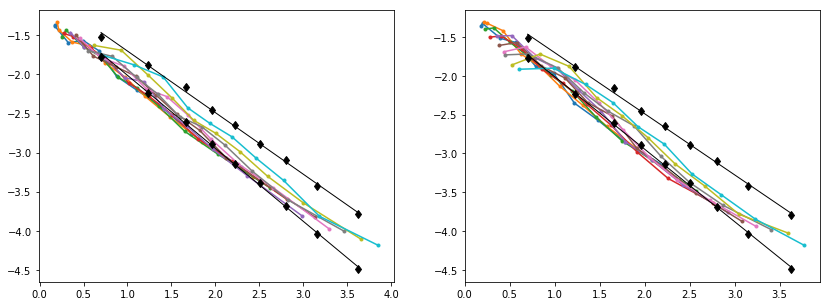

In [62]:
## Exp 3
result = pd.read_csv('./experiment_3.csv')
plot_data = result.loc[result.dist == 'emp'].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


sorting = True

fig, axs = plt.subplots(1, 2, figsize = (14, 5))

poly_list = []
for i in [0, 1]:
    ax = axs[i]
    for N in n_vals:
        plot_data_3 = block_var_n.loc[(block_var_n.IMPORT == i) & (block_var_n.sorting == sorting) & (block_var_n.N == N) ]
#         plot_data_2 = block_var_n.loc[(block_var_n.IMPORT == i) & (block_var_n.p == p) & (block_var_n.sorting == sorting)]
        x = np.log10(plot_data_3['n'].values); y = np.log10(plot_data_3.var_logSp.values);
        ax.plot(x, y, marker = '.')
        
        z = np.polyfit(x, y, 1)
        poly = np.poly1d(z)
    #     xp = np.arange(3, 4.5, .25) 
        poly_list += [[i, p, poly[1]]]
        
    for s in [0.30000000000000004, 0.4]:
        data = plot_data.loc[s]['std']

        x = np.log10(data.index.values)
        y1 = 2*np.log10(data['mean'].values)
        ax.plot(x, y1, marker = 'd', c = 'k', lw = 0)
        z = np.polyfit(x, y1, 1)
        poly = np.poly1d(z);
        ax.plot(x, poly(x), lw = 1, c = 'k')
        print(poly)

display(pd.DataFrame(poly_list, columns = ['IMPORT', 'p', 'alpha']).groupby(['IMPORT'])[['alpha']].describe())
    

In [47]:
xx

NameError: name 'xx' is not defined

In [ ]:
df_s2 = df.drop(['Eij', 'ME', 'M'])
df_s2log = Q**2*df.drop(['Eij', 'ME', 'M']).div((np.log(10)**2*X_df**2).T.values, axis = 1) ## Should in fact divide by Sp, instead of Q/bar X
df_x = nqs_df['mean'].unstack()

fig, axs = plt.subplots(1, figsize = (6, 5))

for i in range(Q):
    y = np.log10(df_s2log.iloc[i])
    x = np.log10(df_x.iloc[i])
    plt.plot(x, y, marker = '.')
    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
#     xp = np.arange(3, 4.5, .25) 
    print(p)
        

plt.show()

In [ ]:
M = 50

block_res = []
X_n = []

logn_vals = np.arange(3, np.log10(len(filt_fm)), .25)
n_vals = np.round(10**logn_vals, -2)


nmqs  = []
    
for n in n_vals:
    X_list = []
    s_list = []

    for m in range(M):
        n_sample = filt_fm.sample(int(n))
        s = np.log10(n_sample.sum()).std()
        bar_X = n_sample.sum().mean()
        X_list += [bar_X]
        s_list += [s]

        sort_sample = n_sample.loc[n_sample.sum(1).sort_values().index]
        sort_sample['q'] = pd.cut(sort_sample.sum(1).cumsum(), Q, labels = range(Q))

        ### Quantile subtotals
        n_m_q_out = sort_sample.groupby('q').sum().reset_index()
        n_m_q_out['m'] = m
        n_m_q_out['n'] = n
        nmqs += [n_m_q_out]
        
        
nmqs_df = pd.concat(nmqs)

## Comovement and residual
medians = nmqs_df.groupby(['n', 'q']).transform('median'); medians.index = pd.MultiIndex.from_arrays(nmqs_df[['n', 'q']].values.T); medians.index.names = ['n', 'q']
res_nmq = nmqs_df.set_index(['n', 'q']) - medians; 

## Organize info
medians['m'] = nmqs_df['m'].values; medians['comp'] = 'm'; medians = medians.reset_index()
res_nmq['m'] = nmqs_df['m'].values; res_nmq['comp'] = 'se'; res_nmq = res_nmq.reset_index()
# res_nmq['q'] = nmqs_df['q']; res_nmq['m'] = nmqs_df['m']; res_nmq['comp'] = 'se'; res_nmq['n'] = nmqs_df['m']

info = pd.concat([medians, res_nmq])

In [ ]:
M = 150

block_res = []
X_n = []

logn_vals = np.arange(3, np.log10(len(filt_fm)), .25)
n_vals = np.round(10**logn_vals, -2)

for n in n_vals:
    X_list = []
    s_list = []
    nmqs  = []

    for m in range(M):
        n_sample = filt_fm.sample(int(n))
        s = np.log10(n_sample.sum()).std()
        bar_X = n_sample.sum().mean()
        X_list += [bar_X]
        s_list += [s]

        sort_sample = n_sample.loc[n_sample.sum(1).sort_values().index]
        sort_sample['q'] = pd.cut(sort_sample.sum(1).cumsum(), Q, labels = range(Q))

        ### Quantile subtotals
        n_m_q_out = sort_sample.groupby('q').sum().reset_index()
        n_m_q_out['m'] = m
        nmqs += [n_m_q_out]
    nmqs_df = pd.concat(nmqs)

    ## Comovement and residual
    medians = nmqs_df.groupby('q').transform('median')
    res_nmq = nmqs_df.set_index('q') - medians; 
    medians['q'] = nmqs_df['q']; medians['m'] = nmqs_df['m']; medians['comp'] = 'm'
    res_nmq['q'] = nmqs_df['q']; res_nmq['m'] = nmqs_df['m']; res_nmq['comp'] = 'se'

#     res_nmq['std'] = res_nmq.std(1)
#     nq_stds = res_nmq.groupby(level = 'q')['std'].describe()

    ### Cov Matrix
    info = pd.concat([medians, res_nmq])

    X_n += [np.mean(np.array(X_list))]
    
    cov_vals = []
    for m in range(M):
        cov_m = info.loc[info.m == m].drop('m', axis = 1).set_index(['comp', 'q']).T.cov() #
        cov_vals += [cov_m.stack([0, 1])]


    n_cov_vals = pd.concat(cov_vals, axis = 1)

    df = n_cov_vals.copy()
    df.index.names = ['comp1', 'q1', 'comp2', 'q2']

    df = df.reset_index()

    df.loc[(df.comp1 == 'm') & (df.comp2 == 'm'), 'block'] = 'M'
    df.loc[(df.comp1 == 'se') & (df.comp2 == 'se') & (df.q1 == df.q2), 'block'] = 'E' + df.loc[(df.comp1 == 'se') & (df.comp2 == 'se') & (df.q1 == df.q2), 'q1'].astype(str)
    df.loc[(df.comp1 == 'se') & (df.comp2 == 'se') & (df.q1 != df.q2), 'block'] = 'Eij'
    df.loc[df.comp1 != df.comp2, 'block'] = 'ME'

    block_sums_n = df.groupby('block')[np.arange(M)].sum()
    block_vals = pd.DataFrame(block_sums_n.mean(1), columns=[n])
    block_res += [block_vals]
    
X_df = pd.DataFrame(X_n, index = n_vals, columns = ['bar X'])